# Expedited shipping

This notebook contains the code to run all the analyses we report in a paper revision. Please refer to this repo's README to get a sense of the experiment and the rationale of the analyses we report in this notebook.

## Libraries

We start by loading all the necessary libraries and supporting scripts to run the analyses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from linearmodels import RandomEffects
import statsmodels as sm
import helper_functions as h_f

## Basic data wrangling

We perform a basic data wrangling to engineer additional features that will allow us to run random-effects (RE) models and simplify the interpretation of the regression results associated with categorical variables.

In [2]:
# We tell pandas we want to see all the columns from our dataset
pd.set_option("display.max_columns", None)

# We load the dataset
rawData = pd.read_csv("raw_data_r1.csv")
rawData.head()

,subject_id,round,overall_round,price,cost,service_level,expediting_cost,salvage_value,optimum,order,demand,leftover,shortage,lagleftover,lagshortage,lagdemand,gender,age,semester,related_course,program,treatment_id,included_treatment,study,experiment,playing_order,bundle
0,1,1,1,12,3.0,0.0,0,0,75.0,95,32,63,0,NaN,NaN,NaN,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN
1,1,2,2,12,3.0,0.0,0,0,75.0,30,43,0,13,63.0,0.0,32.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN
2,1,3,3,12,3.0,0.0,0,0,75.0,45,13,32,0,0.0,13.0,43.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN
3,1,4,4,12,3.0,0.0,0,0,75.0,50,12,38,0,32.0,0.0,13.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN
4,1,5,5,12,3.0,0.0,0,0,75.0,74,6,68,0,38.0,0.0,12.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN


In [3]:
# We create the feature 'expediting_level' to capture the three main expediting levels: profitable, breakeven
# and unprofitable
expeditingDict = {4: "Profitable",
                   6: "Profitable",
                   12: "Breakeven",
                   18: "Unprofitable",
                   30: "Unprofitable"}
rawData["expediting_level"] = rawData["expediting_cost"].map(expeditingDict)

# We revise the feature 'related_course' to simply capture whether a subject has operations management experience
# (current or previous) or not
relatedCourseDict = {"Past semesters": "Yes",
                       "Currently attending": "Yes",
                       "No": "No"
}
rawData["related_course_r"] = rawData["related_course"].map(relatedCourseDict)

# We compute an additional performance metric: an order quantity's absolute distance to the optimal order quantity.
# Our main performance metric are participants' order quantity decisions, which are captured in the feature 'order'
rawData["distance_opt"] = abs(rawData["order"] - rawData["optimum"])

# We create a copy of the feature 'round' to be able to use it as independent variable in RE models
rawData["round_r"] = rawData["round"]

# A subject in the Salience Experiment played three treatments and these treatments have the same subject id.
# We create different subject ids for these treatments. The code below does the same for the subjects in the
# Contract Experiment. However, the paper revision doesn't include any analysis with the Contract Experiment
    # https://datascience.stackexchange.com/questions/89245/pandas-create-a-integer-primary-key-based-in-string-columns-python
rawData["temp"] = rawData["subject_id"].astype(str) + rawData["experiment"].astype(str) + \
    rawData["treatment_id"].astype(str)
rawData["subject_id_r"] = pd.factorize(rawData["temp"])[0]
rawData.drop("temp", axis = 1, inplace = True)

# We assign the normalized expected profit to each order quantity and compute an additional performance metric:
# an order quantity's proportion of maximum expected profit achieved
    # https://kanoki.org/2022/02/11/how-to-return-multiple-columns-using-pandas-apply/
rawData = h_f.assign_exp_profit(rawData)

# We compute an additional performance metric: an order quantity's percent deviation from the optimal order quantity
rawData["percent_deviation_opt"] = abs(rawData["order"] - rawData["optimum"])/rawData["optimum"]

# An unreported cleaning process allowed us to identify a participant from the Main Experiment who reported gender as
# 'Other'. We revise the feature 'gender' to capture this participant as different from 'Male', which allows us to
# include the participant in the RE models. The RE models without this participant deliver virtually the same results
rawData["gender_r"] = np.where(rawData["gender"] == "Male", 1, 0)

# We save the revised dataset to use it later in Stata
rawData.to_csv("raw_data_r1_Stata.csv")

rawData.head()

,subject_id,round,overall_round,price,cost,service_level,expediting_cost,salvage_value,optimum,order,demand,leftover,shortage,lagleftover,lagshortage,lagdemand,gender,age,semester,related_course,program,treatment_id,included_treatment,study,experiment,playing_order,bundle,expediting_level,related_course_r,distance_opt,round_r,subject_id_r,exp_profit_norm,proportion_max_exp_profit,percent_deviation_opt,gender_r
0,1,1,1,12,3.0,0.0,0,0,75.0,95,32,63,0,NaN,NaN,NaN,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN,NaN,Yes,20.0,1,0,0.0,0.0,0.266667,0
1,1,2,2,12,3.0,0.0,0,0,75.0,30,43,0,13,63.0,0.0,32.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN,NaN,Yes,45.0,2,0,0.0,0.0,0.600000,0
2,1,3,3,12,3.0,0.0,0,0,75.0,45,13,32,0,0.0,13.0,43.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN,NaN,Yes,30.0,3,0,0.0,0.0,0.400000,0
3,1,4,4,12,3.0,0.0,0,0,75.0,50,12,38,0,32.0,0.0,13.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN,NaN,Yes,25.0,4,0,0.0,0.0,0.333333,0
4,1,5,5,12,3.0,0.0,0,0,75.0,74,6,68,0,38.0,0.0,12.0,Female,2.0,7.0,Past semesters,Business,1,0,Base study,Main,NaN,NaN,NaN,Yes,1.0,5,0,0.0,0.0,0.013333,0


### Notes

- The dataset contains data from 21 treatments. We work with data from the 12 treatments that are part of the Main and Salience experiments.
- We implemented the **Salience Experiment** using a within-subjects design so that each participant played three salience treatments. We perform several robustness checks to rule out effects related to this design choice.

## 1. Main Experiment

### 1.1. Model-free results

We plot the main results from the **Main Experiment** using boxplots. The boxplots represent participants’ average orders
during the experiment, the gray cross marks indicate the optimal orders for each treatment and the horizontal black dashed line represents the mean demand.

Some sources we followed to construct the plot were:
- [Boxplot demo](https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html)
- [Control colors in a Seaborn boxplot](https://www.python-graph-gallery.com/33-control-colors-of-boxplot-seaborn)
- [Seaborn scatter plots in Python: Complete guide]( https://datagy.io/python-seaborn-scatterplot/)

In [4]:
# We take data from the Main and Salience experiments
main_salience = rawData[((rawData["experiment"] == "Main") & (rawData["included_treatment"] == 1)) \
    | (rawData["experiment"] == "Salience")].copy()

# We compute participants' average orders from the Main treatments
mainOrders = main_salience[main_salience["experiment"] == "Main"].\
    groupby(["expediting_cost", "subject_id"])["order"].mean().reset_index()
mainOrders.drop("subject_id", axis = 1, inplace = True)

# We change the column type of the feature 'expediting_cost' to allow having different plots together in the same
# plot area
mainOrders["expediting_cost"] = mainOrders["expediting_cost"].astype("str")

# We create a DataFrame for adding optimal orders on the boxplots
optimalOrders = [["4", 25], ["6", 50], ["12", 75], ["18", 83.33], ["30", 90]]
optimalOrdersDF = pd.DataFrame(optimalOrders, columns=["ec", "opt"])

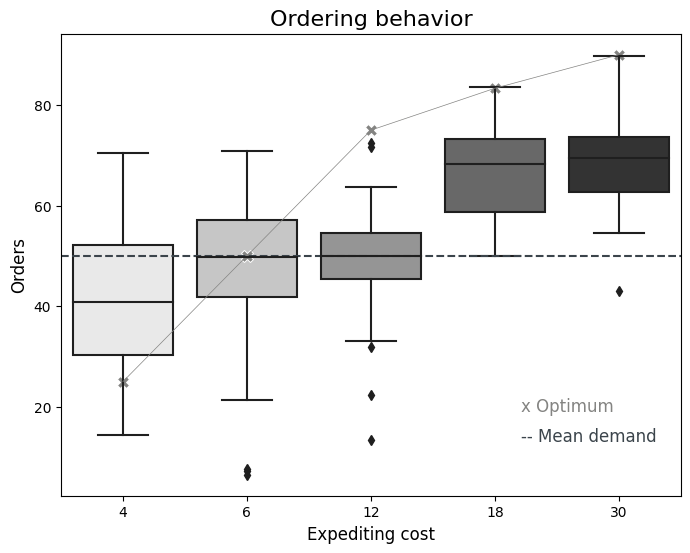

In [5]:
# We create the boxplot
fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(x = "expediting_cost", y = "order", data = mainOrders, palette = "Greys", ax = ax)

# We add the optimal orders
sns.scatterplot(x = "ec", y = "opt", data = optimalOrdersDF, s = 75, color = "#848482", marker = "X", ax = ax)
sns.lineplot(x = "ec", y = "opt", data = optimalOrdersDF, linewidth = 0.5, color = "#848482", ax = ax)

# We add the mean demand
plt.axhline(y = 50, color = "#3B444B", ls = "--")

# We add axis labels
plt.xlabel("Expediting cost", fontsize = 12)
plt.ylabel("Orders", fontsize = 12)
plt.title("Ordering behavior", fontsize = 16)

# We add legends
fig.text(0.7, 0.25, "x Optimum", color = "#848482", size = 12)
fig.text(0.7, 0.2, "-- Mean demand", color = "#3B444B", size = 12)

plt.show()

### 1.2. Expediting cost

Using data from the **Main Experiment**, we estimate the effect of expediting costs on ordering decisions using a RE model. The model has the following form:

$Q_{i,t} = \beta_0 + \beta_1 ExpeditingCost_i + \gamma X_{i,t} + u_i + \epsilon_{i,t}$,

where $i$ is an index for participants and $t$ is an index for rounds. $Q_{i,t}$ indicates the ordering decision
made by participant $i$ in round $t$ and $ExpeditingCost_i$ captures the specific expediting cost faced
by participant $i$. $u_i$ are the RE intercepts and $\epsilon_{i,t}$ is the error term. $\gamma X_{i,t}$ represents the control variables and their coefficients.

Some sources we followed to learn RE model implementation in Python were:

- [linearmodels examples](https://bashtage.github.io/linearmodels/panel/examples/examples.html)
- [Using fixed and random effects models for panel data in Python](https://medium.com/pew-research-center-decoded/using-fixed-and-random-effects-models-for-panel-data-in-python-a795865736ab)
- [The random effects regression model for panel data sets](https://timeseriesreasoning.com/contents/the-random-effects-regression-model-for-panel-data-sets/)

In [6]:
# We take the independent variables
independentVariables = ["expediting_cost", "lagdemand", "lagshortage", "lagleftover", "round_r", "gender_r", \
    "age", "semester", "related_course_r"]

# We take the data from the Main Experiment
rawDataMain = rawData[(rawData["experiment"] == "Main") & (rawData["included_treatment"] == 1)].copy()

# We set the indexes to run the RE model
rawDataMain = rawDataMain.set_index(["subject_id_r", "round"])

# We add the constant to the list of independent variables
independentVariables_r = sm.tools.tools.add_constant(rawDataMain[independentVariables])

# We fit the RE model
model = RandomEffects(rawDataMain["order"], independentVariables_r).fit()
print(model)

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.4845
Estimator:              RandomEffects   R-squared (Between):              0.8825
No. Observations:                4669   R-squared (Within):              -0.0663
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.4845
Time:                        15:47:16   Log-likelihood                -1.959e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      486.52
Entities:                         161   P-value                           0.0000
Avg Obs:                       29.000   Distribution:                  F(9,4659)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             486.52
                            

We can replicate the analysis above using a *formula* approach. We'll use this approach in the remainder of this notebook.

```
independentVariables = "expediting_cost + lagdemand + lagshortage + lagleftover + round_r + gender_r + age + \
    semester + related_course_r"
model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, rawDataMain).fit()
print(model)
```

### 1.3. Pull-to-center

Using data from the **Main Experiment**, we compare participants' average orders with both the treatment's optimal order and the mean demand.

#### $k = 4$

In [7]:
# We take participants' average orders from the Main treatments
mainData = main_salience[main_salience["experiment"] == "Main"].\
    groupby(["treatment_id", "subject_id"])["order"].mean().reset_index()

# We take the treatment's optimal order
optimum = rawData[rawData["treatment_id"] == 8]["optimum"].iloc[0]

# We take the treatment data from the Main Experiment
sampleMain = mainData[mainData["treatment_id"] == 8]["order"]

# We compute the t-test comparing the treatment's average ordering behavior with the treatment's optimal order
pingouin.ttest(sampleMain, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.044022,33,two-sided,4.633660e-08,"[36.5, 45.84]",1.20804,3.066e+05,0.999999


In [8]:
# We compute the t-test comparing the treatment's average ordering behavior with the mean demand
pingouin.ttest(sampleMain, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.846154,33,two-sided,0.00052,"[36.5, 45.84]",0.65961,57.324,0.961805


#### $k = 6$

In [9]:
optimum = rawData[rawData["treatment_id"] == 3]["optimum"].iloc[0]
sampleMain = mainData[mainData["treatment_id"] == 3]["order"]
pingouin.ttest(sampleMain, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.454265,31,two-sided,0.155924,"[39.51, 51.76]",0.25708,0.49,0.291328


In [10]:
pingouin.ttest(sampleMain, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.454265,31,two-sided,0.155924,"[39.51, 51.76]",0.25708,0.49,0.291328


#### $k = 12$

In [11]:
optimum = rawData[rawData["treatment_id"] == 4]["optimum"].iloc[0]
sampleMain = mainData[mainData["treatment_id"] == 4]["order"]
pingouin.ttest(sampleMain, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.830934,31,two-sided,5.001930e-13,"[44.97, 53.8]",2.091433,1.561e+10,1.0


In [12]:
pingouin.ttest(sampleMain, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.282457,31,two-sided,0.779471,"[44.97, 53.8]",0.049932,0.196,0.058632


#### $k = 18$

In [13]:
optimum = rawData[rawData["treatment_id"] == 5]["optimum"].iloc[0]
sampleMain = mainData[mainData["treatment_id"] == 5]["order"]
pingouin.ttest(sampleMain, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.551489,31,two-sided,9.477779e-11,"[62.97, 70.13]",1.688481,1.06e+08,1.0


In [14]:
pingouin.ttest(sampleMain, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.419391,31,two-sided,1.310940e-10,"[62.97, 70.13]",1.665129,7.79e+07,1.0


#### $k = 30$

In [15]:
optimum = rawData[rawData["treatment_id"] == 9]["optimum"].iloc[0]
sampleMain = mainData[mainData["treatment_id"] == 9]["order"]
pingouin.ttest(sampleMain, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.716997,30,two-sided,1.010656e-12,"[65.05, 72.45]",2.104435,7.934e+09,1.0


In [16]:
pingouin.ttest(sampleMain, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.337969,30,two-sided,2.097850e-11,"[65.05, 72.45]",1.856754,4.422e+08,1.0


#### Decision rule

We further test pull-to-center behavior by estimating the followig RE decision rule:

$Q_{i,t} = \alpha MeanDemand + (1 - \alpha)Q^*_i + u_i + \epsilon_{i,t}$,

where $\alpha$ is a behavioral parameter that captures the level of anchoring toward the mean demand. Values of $\alpha$ close to zero indicate participants make their ordering decisions following the optimal ordering policy. Values of $\alpha$ close to one indicate participants' orders consistently deviate from the optimal order and place orders closer to the mean demand.

We use all data from the **Main Experiment** to estimate an aggregate behavioral model that uses only one set of behavioral parameters for all participants. We estimate the model following a maximum likelihood (ML) estimation approach.

This analysis is run in **Stata**. We're aware that Python offers integration with Stata, but the Stata version must be version 17 (or newer). Since all the analyses reported in this notebook were run in a computer with Stata 15, we provide the Stata code below.

##### **Stata** code to implement the pull-to-center decision rule

\* Make sure to replace `path_to_csv_file` with the appropriate path to the csv file with the raw data. This file is generated above and saved as `raw_data_r1_Stata.csv`
```
import delimited path_to_csv_file
```

\* Generate a categorical variable from an existing string variable. In this case, we generate a categorical variable that captures the experiment. This variable is later used to filter the appropriate data for the estimation
```
encode experiment, gen(experiment_encoded)
```

\* This is the program that defines the decision rule
```
global panel = "subject_id_r"
capture program drop RE_ANCHORING
program RE_ANCHORING
args todo b lnfj
tempvar anchor q_opt z z2 T a S_z2 S_temp Sz_2 first
tempname sigma_u sigma_e ln_sigma_u ln_sigma_e
mleval `anchor' = `b', eq(1)
mleval `ln_sigma_u' = `b', eq(2) scalar
mleval `ln_sigma_e' = `b', eq(3) scalar 
scalar `sigma_u' = exp(`ln_sigma_u')
scalar `sigma_e' = exp(`ln_sigma_e')
sort $panel
qui {
generate double `q_opt' = $ML_y2
generate double `z' = `anchor'*50 + (1 - `anchor')*`q_opt'
generate double `z2' = $ML_y1 - `z'
by $panel: generate `T' = _N
generate double `a' = `sigma_u'^2 / ( `T' * `sigma_u'^2 + `sigma_e'^2 )
by $panel: egen double `S_z2' = sum( `z2'^2 )
by $panel: egen double `S_temp' = sum( `z2' )
by $panel: generate double `Sz_2' = `S_temp'^2
by $panel: generate `first' = ( _n == 1 )
mlsum `lnfj' = -.5 * ( ( `S_z2' - `a' * `Sz_2' ) / ( `sigma_e'^2 ) + log( `T' * `sigma_u'^2 / `sigma_e'^2 + 1 ) + `T' * log( 2*_pi * `sigma_e'^2 ) ) if `first' == 1
}  
end
```

\* This is the ML estimation
```
ml model d0 RE_ANCHORING ( anchor: order optimum = ) ( ln_sigma_u: ) ( ln_sigma_e: ) if experiment_encoded == 2 & included_treatment == 1, technique(nr)  
ml check
ml maximize, difficult
```

### 1.4. Target fill rates

We take:

- $\eta = 1$, $k = 18$ (`treatment_id = 5`),
- $\eta = 0.5$, $k = 18$ (`treatment_id = 7`) and
- the $newsvendor$ ($\eta = 0$, no $k$) treatment (`treatment_id = 1`)

to analyze the role of target fill rates in ordering decisions. We first compare participants' average orders with both the treatment's optimal order and the mean demand and then compare average orders among the three treatments.

In [17]:
# We take participants' average orders from the treatments of interest
mainDataSL = rawData[(rawData["treatment_id"] == 1) | \
    (rawData["treatment_id"] == 5) | \
    (rawData["treatment_id"] == 7)].groupby(["treatment_id", "subject_id"])["order"].mean().reset_index()

#### $\eta = 1$, $k = 18$

In [18]:
optimum = rawData[rawData["treatment_id"] == 5]["optimum"].iloc[0]
sampleMainSL = mainDataSL[mainDataSL["treatment_id"] == 5]["order"]
pingouin.ttest(sampleMainSL, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.551489,31,two-sided,9.477779e-11,"[62.97, 70.13]",1.688481,1.06e+08,1.0


In [19]:
pingouin.ttest(sampleMainSL, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.419391,31,two-sided,1.310940e-10,"[62.97, 70.13]",1.665129,7.79e+07,1.0


#### $\eta = 0.5$, $k = 18$

In [20]:
optimum = rawData[rawData["treatment_id"] == 7]["optimum"].iloc[0]
sampleMainSL = mainDataSL[mainDataSL["treatment_id"] == 7]["order"]
pingouin.ttest(sampleMainSL, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-12.97556,31,two-sided,4.556234e-14,"[46.73, 54.41]",2.293777,1.542e+11,1.0


In [21]:
pingouin.ttest(sampleMainSL, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.304897,31,two-sided,0.762482,"[46.73, 54.41]",0.053899,0.197,0.060067


#### $Newsvendor$ ($\eta = 0$, no $k$)

In [22]:
optimum = rawData[rawData["treatment_id"] == 1]["optimum"].iloc[0]
sampleMainSL = mainDataSL[mainDataSL["treatment_id"] == 1]["order"]
pingouin.ttest(sampleMainSL, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.014735,30,two-sided,4.598630e-12,"[47.46, 56.07]",1.978305,1.873e+09,1.0


In [23]:
pingouin.ttest(sampleMainSL, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.837014,30,two-sided,0.409203,"[47.46, 56.07]",0.150332,0.264,0.127974


#### Average orders comparison among the three treatments

The boxplot below isn't reported in the paper.

In [24]:
# We drop the feature 'subject_id'
mainDataSL.drop("subject_id", axis = 1, inplace = True)

# We create a dictionary to relabel the treatments so that it's easier to read the results
t_dict = { 1: "NV",
           5: "SL1_k18",
           7: "SL0.5_k18"
}

# We relabel the treatments
mainDataSL["treatment_id"] = mainDataSL["treatment_id"].map(t_dict)

# We set the treatment order for the plots (NV < SL0.5_k18 < SL1_k18)
mainDataSL["treatment_id"] = mainDataSL["treatment_id"].astype("category")
mainDataSL["treatment_id"] = mainDataSL["treatment_id"].cat.set_categories(["NV", "SL0.5_k18", "SL1_k18"], \
    ordered = True)

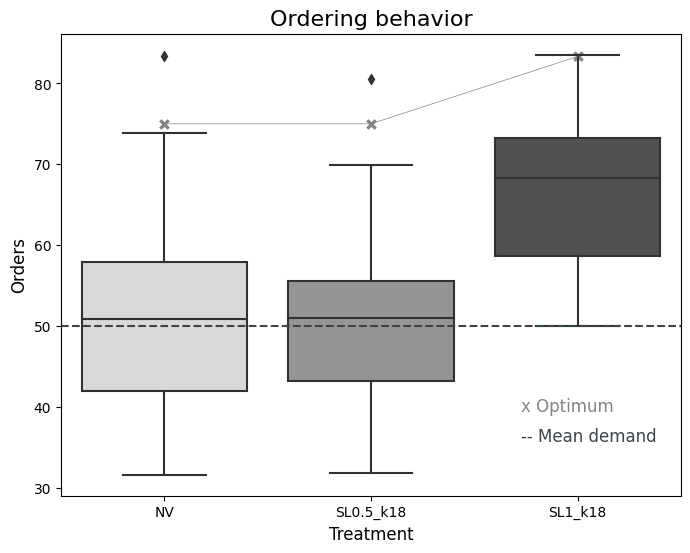

In [25]:
### This plot isn't reported in the paper 

# We create a DataFrame for adding optimal orders on the boxplots
optimalOrders = [["NV", 75], ["SL0.5_k18", 75], ["SL1_k18", 83.33]]
optimalOrdersDF = pd.DataFrame(optimalOrders, columns=["ec", "opt"])

# We create the boxplot
fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(x = "treatment_id", y = "order", data = mainDataSL, palette = "Greys", ax = ax)

# We add the optimal orders
sns.scatterplot(x = "ec", y = "opt", data = optimalOrdersDF, s = 75, color = "#848482", marker = "X", ax = ax)
sns.lineplot(x = "ec", y = "opt", data = optimalOrdersDF, linewidth = 0.5, color = "#848482", ax = ax)

# We add the mean demand
plt.axhline(y = 50, color = "#3B444B", ls = "--")

# We add axis labels
plt.xlabel("Treatment", fontsize = 12)
plt.ylabel("Orders", fontsize = 12)
plt.title("Ordering behavior", fontsize = 16)

# We add legends
fig.text(0.7, 0.25, "x Optimum", color = "#848482", size = 12)
fig.text(0.7, 0.2, "-- Mean demand", color = "#3B444B", size = 12)

plt.show()

In [26]:
# We compare the average orders among the three treatments using a one-way ANOVA
f_oneway(mainDataSL[mainDataSL["treatment_id"] == "NV"]["order"], \
    mainDataSL[mainDataSL["treatment_id"] == "SL0.5_k18"]["order"], \
    mainDataSL[mainDataSL["treatment_id"] == "SL1_k18"]["order"])

F_onewayResult(statistic=21.669273170371717, pvalue=1.9446914957212142e-08)

In [27]:
# We run the Tukey HSD post-hoc comparison tests to check differences among treatment pairs
pairwise_tukeyhsd(mainDataSL["order"], mainDataSL["treatment_id"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
NV,SL0.5_k18,-1.1916,0.8997,-7.6707,5.2874,False
NV,SL1_k18,14.7834,0.0,8.3043,21.2624,True
SL0.5_k18,SL1_k18,15.975,0.0,9.5476,22.4024,True


In [28]:
# For robustness, we run the Games-Howell post-hoc comparison tests to check differences among treatment pairs
h_f.run_games_howell(mainDataSL[["treatment_id", "order"]])

,group,mean_difference,std_error,t_value,p_value,lower_limit,upper_limit
0,NV : SL0.5_k18,-1.191633,1.999152,0.421485,0.900,-7.985995,5.602729
1,NV : SL1_k18,14.783367,1.941166,5.385124,0.001,8.182445,21.384289
2,SL0.5_k18 : SL1_k18,15.975000,1.820767,6.203996,0.001,9.791229,22.158771


## 2. Salience Experiment

We replicate the **expediting cost** and **pull-to-center** analyses.

### 2.1. Expediting cost

In [29]:
# We take the data from the Salience Experiment
rawDataSalience = rawData[rawData["experiment"] == "Salience"].copy()

# We set the indexes to run the RE model
rawDataSalience = rawDataSalience.set_index(["subject_id_r", "round"])

# We use a formula approach
independentVariables = "expediting_cost + lagdemand + lagshortage + lagleftover + round_r + gender_r + age + \
    semester + related_course_r"
model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, rawDataSalience).fit()
print(model)

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.5345
Estimator:              RandomEffects   R-squared (Between):              0.9019
No. Observations:                3306   R-squared (Within):              -0.1183
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.5345
Time:                        15:48:29   Log-likelihood                -1.366e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      420.59
Entities:                         174   P-value                           0.0000
Avg Obs:                       19.000   Distribution:                  F(9,3296)
Min Obs:                       19.000                                           
Max Obs:                       19.000   F-statistic (robust):             420.59
                            

### 2.2. Pull-to-center

#### $k = 4$

In [30]:
# We take participants' average orders from the Salience treatments
salienceData = main_salience[main_salience["experiment"] == "Salience"].\
    groupby(["treatment_id", "subject_id"])["order"].mean().reset_index()

optimum = rawData[rawData["treatment_id"] == 10]["optimum"].iloc[0]
sampleSalience = salienceData[salienceData["treatment_id"] == 10]["order"]
pingouin.ttest(sampleSalience, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.340553,33,two-sided,3.553396e-07,"[41.19, 56.48]",1.087396,4.56e+04,0.999986


In [31]:
pingouin.ttest(sampleSalience, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.31065,33,two-sided,0.75802,"[41.19, 56.48]",0.053276,0.192,0.060492


#### $k = 6$

In [32]:
optimum = rawData[rawData["treatment_id"] == 11]["optimum"].iloc[0]
sampleSalience = salienceData[salienceData["treatment_id"] == 11]["order"]
pingouin.ttest(sampleSalience, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.367967,34,two-sided,0.180296,"[48.4, 58.18]",0.231229,0.426,0.264686


In [33]:
pingouin.ttest(sampleSalience, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.367967,34,two-sided,0.180296,"[48.4, 58.18]",0.231229,0.426,0.264686


#### $k = 12$

In [34]:
optimum = rawData[rawData["treatment_id"] == 12]["optimum"].iloc[0]
sampleSalience = salienceData[salienceData["treatment_id"] == 12]["order"]
pingouin.ttest(sampleSalience, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.970395,34,two-sided,9.408796e-07,"[55.58, 65.44]",1.009181,1.835e+04,0.999937


In [35]:
pingouin.ttest(sampleSalience, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.331509,34,two-sided,0.000124,"[55.58, 65.44]",0.732159,206.505,0.987657


#### $k = 18$

In [36]:
optimum = rawData[rawData["treatment_id"] == 13]["optimum"].iloc[0]
sampleSalience = salienceData[salienceData["treatment_id"] == 13]["order"]
pingouin.ttest(sampleSalience, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.952619,34,two-sided,2.894806e-09,"[62.09, 70.74]",1.344238,4.171e+06,1.0


In [37]:
pingouin.ttest(sampleSalience, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.716881,34,two-sided,5.646991e-09,"[62.09, 70.74]",1.304391,2.219e+06,1.0


#### $k = 30$

In [38]:
optimum = rawData[rawData["treatment_id"] == 14]["optimum"].iloc[0]
sampleSalience = salienceData[salienceData["treatment_id"] == 14]["order"]
pingouin.ttest(sampleSalience, optimum)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.197564,34,two-sided,1.455685e-09,"[67.4, 76.38]",1.385641,7.989e+06,1.0


In [39]:
pingouin.ttest(sampleSalience, 50)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.90574,34,two-sided,1.485905e-11,"[67.4, 76.38]",1.674376,6.216e+08,1.0


#### **Stata** code to estimate the pull-to-center decision rule

```
ml model d0 RE_ANCHORING ( anchor: order optimum = ) ( ln_sigma_u: ) ( ln_sigma_e: ) if experiment_encoded == 3, technique(nr)  
ml check
ml maximize, difficult
```

### 2.3. Salience results

Using data from both experiments, we estimate the effect of salience on ordering decisions under different expediting cost levels using a RE model. The model has the following form:

$Q_{i,t} = \beta_0 + \beta_1 ExpeditingCost_i + \beta_2 Salience_i + \beta_3 ExpeditingCost_i \times Salience_i + \gamma X_{i,t} + u_i + \epsilon_{i,t}$,

where $i$ is an index for participants and $t$ is an index for rounds. $Q_{i,t}$ indicates the ordering decision
made by participant $i$ in round $t$, $ExpeditingCost_i$ captures the specific expediting cost faced
by participant $i$ and $Salience_i$ is an indicator variable for the **Salience Experiment**, leaving the **Main Experiment** as the reference. We also consider the interaction between expediting costs and salience to capture how the expediting costs moderate the relationship between salience and ordering decisions. $u_i$ are the RE intercepts and $\epsilon_{i,t}$ is the error term. $\gamma X_{i,t}$ represents the control variables and their coefficients.

We further explore the interaction effect by deriving its exact marginal effects. This analysis is run in **Stata**. We provide the Stata code below.

#### Model with no interaction term

In [40]:
# We take the data from the Main and Salience Experiments
rawDataMainSalience = rawData[((rawData["experiment"] == "Main") & (rawData["included_treatment"] == 1)) \
    | (rawData["experiment"] == "Salience")].copy()

rawDataMainSalience = rawDataMainSalience.set_index(["subject_id_r", "round"])
independentVariables = "expediting_cost + experiment + lagdemand + lagshortage + lagleftover + round_r + gender_r + \
    age + semester + related_course_r"
model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, rawDataMainSalience).fit()
print(model)

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.5093
Estimator:              RandomEffects   R-squared (Between):              0.8900
No. Observations:                7975   R-squared (Within):              -0.0969
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.5093
Time:                        15:49:40   Log-likelihood                 -3.33e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      826.62
Entities:                         335   P-value                           0.0000
Avg Obs:                       23.806   Distribution:                 F(10,7964)
Min Obs:                       19.000                                           
Max Obs:                       29.000   F-statistic (robust):             826.62
                            

#### Model with interaction term

In [41]:
independentVariables = "expediting_cost + experiment + expediting_cost*experiment + lagdemand + lagshortage + \
    lagleftover + round_r + gender_r + age + semester + related_course_r"
model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, rawDataMainSalience).fit()
print(model)

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.5099
Estimator:              RandomEffects   R-squared (Between):              0.8902
No. Observations:                7975   R-squared (Within):              -0.0956
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.5099
Time:                        15:49:42   Log-likelihood                 -3.33e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      753.14
Entities:                         335   P-value                           0.0000
Avg Obs:                       23.806   Distribution:                 F(11,7963)
Min Obs:                       19.000                                           
Max Obs:                       29.000   F-statistic (robust):             753.14
                            

#### **Stata** code to estimate the marginal effects

\* Make sure to replace `path_to_csv_file` with the appropriate path to the csv file with the raw data
```
import delimited path_to_csv_file
```

\* Set the indexes to run a RE model  
```
xtset subject_id_r round
```

\* Generate categorical variables from existing string variables. In this case, we generate a categorical variable that captures the experiment. This variable is later used to filter the appropriate data for the estimation. We also generate a categorical variable that captures a piece of demographic information
```
encode experiment, gen(experiment_encoded)
encode related_course_r, gen(related_course_r_encoded)
```

\* RE estimation
```
xtreg order c.expediting_cost##ib2.experiment_encoded lagdemand lagshortage lagleftover round i.gender_r age semester i.related_course_r_encoded if ((experiment_encoded == 2 & included_treatment == 1) | experiment_encoded == 3), re
```

\* Marginal effects estimation. We include a plot to see the results graphically
```
margins ib2.experiment_encoded, at(expediting_cost = (4 6 12 18 30))
marginsplot
```

## 3. Robustness checks

### 3.1. Expediting cost

The **Expediting cost** analysis reported in the **Main Experiment** is consistent across two different operationalizations of the expediting cost that separate the expediting cost:

1. by expediting level, i.e., profitable, breakeven and unprofitable, and
2. by treatment, i.e., treating the expediting cost as categorical variable.

These results are reported in the paper's e-companion.

The following source helped us organize the data for the second robustness check:

- [Pandas DataFrame sort by categorical column but by specific class ordering](https://stackoverflow.com/questions/39223256/pandas-dataframe-sort-by-categorical-column-but-by-specific-class-ordering)

#### Using the feature `expediting_level`, with `Breakeven` expediting as the reference

In [42]:
independentVariables = "expediting_level + lagdemand + lagshortage + lagleftover + round_r + gender_r + age + \
    semester + related_course_r"
model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, rawDataMain).fit()
print(model)

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.4897
Estimator:              RandomEffects   R-squared (Between):              0.8831
No. Observations:                4669   R-squared (Within):              -0.0547
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.4897
Time:                        15:49:51   Log-likelihood                -1.957e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      447.02
Entities:                         161   P-value                           0.0000
Avg Obs:                       29.000   Distribution:                 F(10,4658)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             447.02
                            

#### Using the feature `expediting_cost` as categorical variable, with $k = 12$ as the reference

In [43]:
independentVariables = "expediting_cost + lagdemand + lagshortage + lagleftover + round_r + gender_r + age + \
    semester + related_course_r"

# We set 'k = 12 as' the reference category
rawDataMain["expediting_cost"] = rawDataMain["expediting_cost"].astype("category")
categoryOrdering = [12, 4, 6, 18, 30]  
rawDataMain["expediting_cost"] = rawDataMain["expediting_cost"].cat.reorder_categories(categoryOrdering, ordered = True)

model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, rawDataMain).fit()
print(model)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.4916
Estimator:              RandomEffects   R-squared (Between):              0.8839
No. Observations:                4669   R-squared (Within):              -0.0514
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.4916
Time:                        15:49:55   Log-likelihood                -1.956e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      375.12
Entities:                         161   P-value                           0.0000
Avg Obs:                       29.000   Distribution:                 F(12,4656)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             375.12
                            

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


### 3.2. Order-of-presentation effects

#### 3.2.1. Three orders of play

In the **Salience Experiment**, each participant played three treatments. Their order of presentation was randomized. Nonetheless, we compare ordering performance among the three orders of play to rule out that our findings are driven by the order in which we presented the treatments to participants.

Results show we can rule out order-of-presentation effects. These results are reported in the e-companion.

In [44]:
# We take participants' average orders from the Salience treatments for 'playing_order = 1', 'playing_order = 2'
# and 'playing_order = 3'. We only filter by 'playing_order' since the Contract treatments were already filtered out
# and the Main treatments have 'playing_order = NaN'
salience_first = main_salience[main_salience["playing_order"] == 1].\
    groupby(["treatment_id", "subject_id"])["order"].mean().reset_index()
salience_middle = main_salience[main_salience["playing_order"] == 2].\
    groupby(["treatment_id", "subject_id"])["order"].mean().reset_index() 
salience_last = main_salience[main_salience["playing_order"] == 3].\
    groupby(["treatment_id", "subject_id"])["order"].mean().reset_index()

#### $k = 4$

In [45]:
# We take data from 'k = 4'
sample_salience_f = salience_first[salience_first["treatment_id"] == 10]["order"]
sample_salience_m = salience_middle[salience_middle["treatment_id"] == 10]["order"]
sample_salience_l = salience_last[salience_last["treatment_id"] == 10]["order"]

# We compute the one-way ANOVA
f_oneway(sample_salience_f, sample_salience_m, sample_salience_l)

F_onewayResult(statistic=1.9581126956195578, pvalue=0.1581915516658052)

In [46]:
# As a robustness check, we also compute a Kruskal-Wallis test
kruskal(sample_salience_f, sample_salience_m, sample_salience_l)

KruskalResult(statistic=4.522857142857163, pvalue=0.10420151906308554)

#### $k = 6$

In [47]:
sample_salience_f = salience_first[salience_first["treatment_id"] == 11]["order"]
sample_salience_m = salience_middle[salience_middle["treatment_id"] == 11]["order"]
sample_salience_l = salience_last[salience_last["treatment_id"] == 11]["order"]
f_oneway(sample_salience_f, sample_salience_m, sample_salience_l)

F_onewayResult(statistic=0.9551147123020116, pvalue=0.39546495537580945)

In [48]:
kruskal(sample_salience_f, sample_salience_m, sample_salience_l)

KruskalResult(statistic=2.0344877344877403, pvalue=0.36159015854636767)

#### $k = 12$

In [49]:
sample_salience_f = salience_first[salience_first["treatment_id"] == 12]["order"]
sample_salience_m = salience_middle[salience_middle["treatment_id"] == 12]["order"]
sample_salience_l = salience_last[salience_last["treatment_id"] == 12]["order"]
f_oneway(sample_salience_f, sample_salience_m, sample_salience_l)

F_onewayResult(statistic=0.10258366590815532, pvalue=0.9027982176339291)

In [50]:
kruskal(sample_salience_f, sample_salience_m, sample_salience_l)

KruskalResult(statistic=0.20515138781004738, pvalue=0.9025098326738075)

#### $k = 18$

In [51]:
sample_salience_f = salience_first[salience_first["treatment_id"] == 13]["order"]
sample_salience_m = salience_middle[salience_middle["treatment_id"] == 13]["order"]
sample_salience_l = salience_last[salience_last["treatment_id"] == 13]["order"]
f_oneway(sample_salience_f, sample_salience_m, sample_salience_l)

F_onewayResult(statistic=0.8158370866636832, pvalue=0.45125690765280124)

In [52]:
kruskal(sample_salience_f, sample_salience_m, sample_salience_l)

KruskalResult(statistic=1.7245090297766292, pvalue=0.4222091317272815)

#### $k = 30$

In [53]:
sample_salience_f = salience_first[salience_first["treatment_id"] == 14]["order"]
sample_salience_m = salience_middle[salience_middle["treatment_id"] == 14]["order"]
sample_salience_l = salience_last[salience_last["treatment_id"] == 14]["order"]
f_oneway(sample_salience_f, sample_salience_m, sample_salience_l)

F_onewayResult(statistic=0.3005907632178378, pvalue=0.7424482936337224)

In [54]:
kruskal(sample_salience_f, sample_salience_m, sample_salience_l)

KruskalResult(statistic=0.7563492063492134, pvalue=0.6851108676895694)

#### 3.2.2. Salience's first order of play and Main

In the **Salience Experiment**, each participant played three treatments. We replicate the RE estimations that bundle data from both experiments, but considering only the `playing_order = 1` data from the **Salience Experiment**.

Results are consistent with the **Salience results** (Section 2.3). These results aren't reported in the e-companion but in a response letter.

##### Model with no interaction term

In [55]:
# We take data with 'playing_order = 1' from the Salience Experiment
salienceFirst = main_salience[main_salience["playing_order"] == 1].copy()

# We take the data from the Main Experiment. It's necessary to do this again given some manipulations we performed
# above with the feature 'expediting_cost'
rawDataMain = rawData[(rawData["experiment"] == "Main") & (rawData["included_treatment"] == 1)].copy()

# We bundle the Salience data we pulled above with the Main data
bundle = pd.concat([salienceFirst, rawDataMain])

bundle = bundle.set_index(["subject_id_r", "round"])
independentVariables = "expediting_cost + experiment + lagdemand + lagshortage + lagleftover + round_r + gender_r + \
    age + semester + related_course_r"
model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, bundle).fit()
print(model)

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.4768
Estimator:              RandomEffects   R-squared (Between):              0.8743
No. Observations:                5771   R-squared (Within):              -0.0624
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.4768
Time:                        15:50:30   Log-likelihood                -2.422e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      524.95
Entities:                         219   P-value                           0.0000
Avg Obs:                       26.352   Distribution:                 F(10,5760)
Min Obs:                       19.000                                           
Max Obs:                       29.000   F-statistic (robust):             524.95
                            

##### Model with interaction term

In [56]:
independentVariables = "expediting_cost + experiment + expediting_cost*experiment + lagdemand + lagshortage + \
    lagleftover + round_r + gender_r + age + semester + related_course_r"
model = RandomEffects.from_formula("order ~ 1 + " + independentVariables, bundle).fit()
print(model)

/mnt/c/Users/USER/DS_Projects/Paper_expediting/expedited_shipping/.conda/lib/python3.10/site-packages/linearmodels/panel/model.py:2574: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  order   R-squared:                        0.4783
Estimator:              RandomEffects   R-squared (Between):              0.8758
No. Observations:                5771   R-squared (Within):              -0.0600
Date:                Tue, Jun 13 2023   R-squared (Overall):              0.4783
Time:                        15:50:34   Log-likelihood                -2.421e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      479.93
Entities:                         219   P-value                           0.0000
Avg Obs:                       26.352   Distribution:                 F(11,5759)
Min Obs:                       19.000                                           
Max Obs:                       29.000   F-statistic (robust):             479.93
                            

### 3.3. Error structure

The econometric analyses assume effects of previous periods on the current period's order. We check whether the structure of the errors influences the validity of our results. We run three additional regressions for the **Main Experiment** to check the robustness of our results:

1. Using robust standard errors (SE) to account for heteroskedasticity and autocorrelation in the errors.
2. Using a Generalized Least Square (GLS) estimation with AR1 autocorrelation, which allows to consider additional features of the error structure, including autocorrelation.
3. Using a GLS estimation with panel-specific AR1 autocorrelation structure.

This analysis is run in **Stata**. We provide the Stata code below and briefly comment the results.

Results are consistent with the results reported for the **Main Experiment** in the **Expediting cost** analysis (Section 1.2). These results aren't reported in the e-companion but in the response letter.

#### **Stata** code to estimate the additional models

\* Make sure to replace `path_to_csv_file` with the appropriate path to the csv file with the raw data
```
import delimited path_to_csv_file
```

\* Set the indexes to run a RE model  
```
xtset subject_id_r round
```

\* Generate categorical variables from existing string variables. In this case, we generate a categorical variable that captures the experiment. This variable is later used to filter the appropriate data for the estimation. We also generate a dummy variable that captures a piece of demographic information. By dummifying the variable, Stata shows all the estimation output, which doesn't happen if we input the variable as categorical
```
encode experiment, gen(experiment_encoded)
tab related_course_r, gen(r_c)
```

\* RE estimation with robust SE
```
xtreg order expediting_cost lagdemand lagshortage lagleftover round gender_r age semester r_c2 if experiment_encoded == 2 & included_treatment == 1, re vce(r)
```

\* GLS estimation with AR1 autocorrelation
```
xtgls order expediting_cost lagdemand lagshortage lagleftover round gender_r semester r_c2 if experiment_encoded == 2 & included_treatment == 1, corr(ar1)
```

\* GLS estimation with panel-specific AR1 autocorrelation
```
xtgls order expediting_cost lagdemand lagshortage lagleftover round gender_r age semester r_c2 if experiment_encoded == 2 & included_treatment == 1, corr(psar1)
```